In [1]:
import numpy as np
import pandas as pd
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.utils import resample


from src.api_helpers import JudgmentPredictionAPI
from src.eval_helpers import compute_ci

In [ ]:
root = "../data/cases_json/"

### Load Case Paths

In [3]:
metadata_df = pd.read_csv("../data/csvs/metadata.csv", dtype={'case_id': str})
metadata_df.head()

,case_id,file_name,outcome
0,0001,0001_Caselaw_AZ_1490855-Sasha.json,reverse
1,0002,0002_Caselaw_Alaska_11695007-Sasha.json,affirm
2,0029,0029-nm_119_609-Torres v State-Sasha.json,reverse
3,0032,0032-nm_118_685-Baer v Regents of the Universi...,mixed
4,0033,0033-nm_118_385-Diaz ex rel Diaz v Feil-Sasha....,mixed


In [4]:
n_cases = metadata_df.shape[0]
n_cases

471

### Identify cases with missing annotations

In [5]:
missing_annotation_ids = set()
for i in tqdm(range(n_cases)):
    case_id = metadata_df['case_id'][i]
    file_name = metadata_df['file_name'][i]
    file_path = root + file_name
    with open(file_path, encoding='utf-8') as f:
        case_file = json.load(f)
    
    annotations = case_file['annotations']
    if not annotations['Facts'] or not annotations['Procedural History'] or not annotations['Relevant Precedents'] or not annotations['Application of Law to Facts']:
        missing_annotation_ids.add(case_id)

  0%|          | 0/471 [00:00<?, ?it/s]

In [6]:
len(missing_annotation_ids)

77

In [7]:
clean_df = metadata_df[~metadata_df['case_id'].isin(missing_annotation_ids)].reset_index(drop=True)
clean_df.shape

(394, 3)

In [8]:
n_clean_cases = clean_df.shape[0]

In [9]:
# clean_df.to_csv("../data/csvs/clean_df.csv", index=False)

### Test API

Models to try:
- `gpt-4o`
- `o3-mini`
- `Gemini-1.5-Pro`

In [10]:
index = 0
test_case = root + clean_df['file_name'][index]

In [11]:
predictor = JudgmentPredictionAPI()

In [12]:
outcome_gpt4o = predictor.get_outcome(test_case, subtask='c', model='gpt-4o-2024-11-20')
outcome_gpt4o

'reverse'

In [13]:
outcome_o3mini= predictor.get_outcome(test_case, 'c', 'o3-mini-2025-01-31')
outcome_o3mini

'reverse'

In [14]:
outcome_gemini = predictor.get_outcome(test_case, 'c', 'gemini-1.5-pro')
outcome_gemini

'reverse'

# Run for all cases

In [13]:
def run_task_1(model: str):
    results = np.zeros((n_clean_cases, 3), dtype='object')

    for i in tqdm(range(n_clean_cases)):
        case_file_path = root + clean_df['file_name'][i]

        results[i] = [
            predictor.get_outcome(case_file_path, 'a', model),
            predictor.get_outcome(case_file_path, 'b', model),
            predictor.get_outcome(case_file_path, 'c', model),
            ]
        
        print(f"Case {i+1}: {results[i]} | {file_name}")
    
    return results

In [ ]:
results_gpt4o = run_task_1('gpt-4o-2024-11-20')
task_1_df_gpt4o = pd.DataFrame(results_gpt4o, columns=['outcome_1a_gpt4o', 'outcome_1b_gpt4o', 'outcome_1c_gpt4o'], index=clean_df['case_id']).reset_index()

In [ ]:
# task_1_df_gpt4o.to_csv("../data/results/task_1/gpt4o.csv", index=False)

In [ ]:
results_o3mini = run_task_1('o3-mini-2025-01-31')
task_1_df_o3mini = pd.DataFrame(results_o3mini, columns=['outcome_1a_o3mini', 'outcome_1b_o3mini', 'outcome_1c_o3mini'], index=clean_df['case_id']).reset_index()

In [ ]:
# task_1_df_o3mini.to_csv("../data/results/task_1/o3mini.csv", index=False)

In [ ]:
results_gemini = run_task_1('gemini-1.5-pro')
task_1_df_gemini = pd.DataFrame(results_gemini, columns=['outcome_1a_gemini', 'outcome_1b_gemini', 'outcome_1c_gemini'], index=clean_df['case_id']).reset_index()

In [ ]:
# task_1_df_gemini.to_csv("../data/results/task_1/gemini_1_5_pro.csv", index=False)

# Evaluation

In [14]:
task_1_df_gpt4o = pd.read_csv("../data/results/task_1/gpt4o.csv", dtype={'case_id': str})
task_1_df_o3mini = pd.read_csv("../data/results/task_1/o3mini.csv", dtype={'case_id': str})
task_1_df_gemini = pd.read_csv("../data/results/task_1/gemini_1_5_pro.csv", dtype={'case_id': str})

In [15]:
metadata_df = pd.read_csv("../data/csvs/metadata.csv", dtype={'case_id': str})
metadata_df.head()

,case_id,file_name,outcome
0,0001,0001_Caselaw_AZ_1490855-Sasha.json,reverse
1,0002,0002_Caselaw_Alaska_11695007-Sasha.json,affirm
2,0029,0029-nm_119_609-Torres v State-Sasha.json,reverse
3,0032,0032-nm_118_685-Baer v Regents of the Universi...,mixed
4,0033,0033-nm_118_385-Diaz ex rel Diaz v Feil-Sasha....,mixed


In [16]:
master_df = metadata_df.copy()

# merge all the model's scores
master_df = master_df.merge(task_1_df_gpt4o, how='inner', on='case_id')
master_df = master_df.merge(task_1_df_o3mini, how='inner', on='case_id')
master_df = master_df.merge(task_1_df_gemini, how='inner', on='case_id')

# ensure only valid cases are included
master_df = master_df[master_df['outcome_1a_gpt4o'].notna()].reset_index(drop=True)

print(master_df.shape)
master_df.head()

(394, 12)


,case_id,file_name,outcome,outcome_1a_gpt4o,outcome_1b_gpt4o,outcome_1c_gpt4o,outcome_1a_o3mini,outcome_1b_o3mini,outcome_1c_o3mini,outcome_1a_gemini,outcome_1b_gemini,outcome_1c_gemini
0,0001,0001_Caselaw_AZ_1490855-Sasha.json,reverse,affirm,affirm,reverse,affirm,affirm,reverse,reverse,reverse,reverse
1,0002,0002_Caselaw_Alaska_11695007-Sasha.json,affirm,affirm,affirm,affirm,affirm,affirm,affirm,mixed,mixed,affirm
2,0029,0029-nm_119_609-Torres v State-Sasha.json,reverse,affirm,affirm,mixed,affirm,affirm,reverse,reverse,reverse,reverse
3,0032,0032-nm_118_685-Baer v Regents of the Universi...,mixed,mixed,mixed,mixed,mixed,reverse,reverse,mixed,mixed,reverse
4,0033,0033-nm_118_385-Diaz ex rel Diaz v Feil-Sasha....,mixed,affirm,affirm,mixed,affirm,reverse,reverse,reverse,reverse,mixed


### Helpers

In [17]:
def score_subtask(model_suffix):
    ci_a = compute_ci(master_df['outcome'], master_df['outcome_1a_' + model_suffix])
    ci_b = compute_ci(master_df['outcome'], master_df['outcome_1b_' + model_suffix ])
    ci_c = compute_ci(master_df['outcome'], master_df['outcome_1c_' + model_suffix])

    mean = [ci_a[0], ci_b[0], ci_c[0], np.mean([ci_a[0], ci_b[0], ci_c[0]])]
    lower = np.subtract(mean, [ci_a[1], ci_b[1], ci_c[1], np.mean([ci_a[1], ci_b[1], ci_c[1]])])
    upper = np.subtract([ci_a[2], ci_b[2], ci_c[2], np.mean([ci_a[2], ci_b[2], ci_c[2]])], mean)
    error = np.stack((lower, upper), axis=0)

    return mean, error

### `gpt-4o`, `o3-mini`, `gemini-1.5-pro`

In [18]:
f1_mean_gpt4o, f1_error_gpt4o = score_subtask('gpt4o')
f1_mean_o3mini, f1_error_o3mini = score_subtask('o3mini')
f1_mean_gemini, f1_error_gemini = score_subtask('gemini')

### Random Baseline

In [21]:
np.random.seed(0)
random_preds = np.random.choice(['affirm', 'reverse', 'mixed'], size=(master_df['outcome'].shape))

In [22]:
f1_ci_random = compute_ci(master_df['outcome'], random_preds)

### Plot

In [23]:
f1_means = np.array([f1_mean_gpt4o, f1_mean_o3mini, f1_mean_gemini])
f1_errors = np.array([f1_error_gpt4o, f1_error_o3mini, f1_error_gemini])

labels = ['GPT-4o', 'o3-mini', 'Gemini 1.5 Pro']

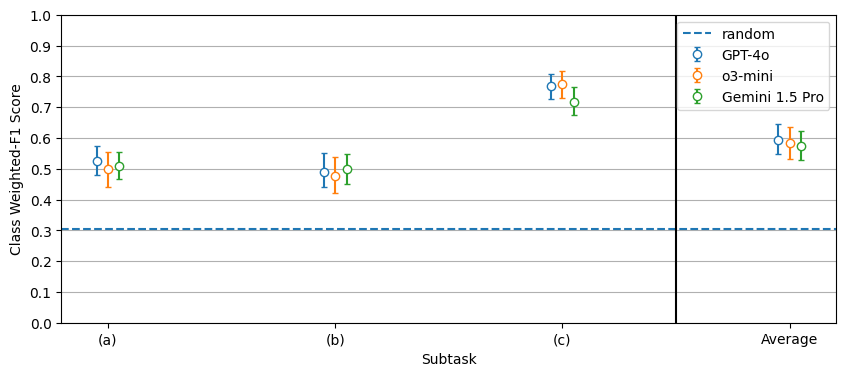

In [24]:
fig = plt.figure(figsize=(10, 4))
# x_axis_labels = ['Facts only', '+ Precedents', '+ Application of Law to Facts']
x_axis_labels = ['(a)', '(b)', '(c)', 'Average']

for i in range(f1_means.shape[0]):
    x_axis = [k-0.05+i*0.05 for k in range(4)]
    plt.errorbar(x_axis, f1_means[i], yerr=f1_errors[i], fmt='o', markerfacecolor='white', capsize=2, label=f"{labels[i]}")

plt.axhline(f1_ci_random[0], linestyle='dashed', label='random')


xticks = range(4)

plt.axvline(2.5, linestyle='solid', c='black')
plt.ylim([0, 1.0])
plt.xlabel("Subtask")
plt.yticks(np.linspace(0, 1, 11))
plt.grid(axis='y', which='major')
plt.xticks(xticks, labels=x_axis_labels)
# ax.text(0.0, 1.04, f"$({string.ascii_lowercase[i]})$", transform=ax.transAxes, size=20, weight='normal')

# axes[0].ylabel("Accuracy")
plt.ylabel("Class Weighted-F1 Score")
# plt.suptitle("Task #1: Accuarcy & F1 Score")
plt.legend(loc='upper right')


# plt.savefig("../figures/task_1_final.png", dpi=300, bbox_inches='tight')
plt.show()